#Homework 3

https://github.com/BME-SmartLab-Education/vitmav45/blob/master/kishazi/3-kis-hazi-feladat.md

Nagy Viktor (JBV582)

Part of this solution is based on [code by peustr](https://github.com/peustr/wavenet). I expanded and modified his code as part of my work in generating audio and applied it to the problem of daily mean temperature prediction. For brevity, I removed the unnecessary functions.

##WaveNet



Imports:

In [1]:
%tensorflow_version 2.x
%pylab inline

import os, time, datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Add, Conv1D, Dense, Flatten, Input, Multiply
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

TensorFlow 2.x selected.
Populating the interactive namespace from numpy and matplotlib


Functions to generate the standard Deep Mind WaveNet in Keras. My variant uses 'causal' setting for the convolution layer padding, as required for causal convolution. This means that any padding is applied to the beginning of the time series.

In [0]:
# Original: https://github.com/peustr/wavenet/blob/master/wavenet/model.py


def WaveNetResidualConv1D(num_filters, kernel_size, dilation_rate):
    """ Function that creates a residual block for the WaveNet with gated
        activation units, skip connections and residual output, as described
        in Sections 2.3 and 2.4 of the paper [1].
        Args:
            num_filters (int): Number of filters used for convolution.
            kernel_size (int): The size of the convolution.
            dilation_rate (int): The dilation rate for the dilated convolution.
        Returns:
            A layer wrapper compatible to the Keras functional API.
        See:
            [1] Oord, Aaron van den, et al. "Wavenet: A generative model for
                raw audio." arXiv preprint arXiv:1609.03499 (2016).
    """
    def build_residual_block(l_input):
        # Gated activation.
        l_sigmoid_conv1d = Conv1D(
            num_filters, kernel_size, dilation_rate=dilation_rate,
            padding="causal", activation="sigmoid")(l_input)
        l_tanh_conv1d = Conv1D(
            num_filters, kernel_size, dilation_rate=dilation_rate,
            padding="causal", activation="tanh")(l_input)
        l_mul = Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
        # Branches out to skip unit and residual output.
        l_skip_connection = Conv1D(1, 1)(l_mul)
        l_residual = Add()([l_input, l_skip_connection])
        return l_residual, l_skip_connection
    return build_residual_block


def build_wavenet_model(input_size, num_filters, kernel_size, num_residual_blocks):
    """ Returns an implementation of WaveNet, as described in Section 2
        of the paper [1].
        Args:
            input_size (int): The size of the waveform the network will
                consider as input.
            num_filters (int): Number of filters used for convolution.
            kernel_size (int): The size of the convolution.
            num_residual_blocks (int): How many residual blocks to generate
                between input and output. Residual block i will have a dilation
                rate of 2^(i+1), i starting from zero.
        Returns:
            A Keras model representing the WaveNet.
        See:
            [1] Oord, Aaron van den, et al. "Wavenet: A generative model for
                raw audio." arXiv preprint arXiv:1609.03499 (2016).
    """
    l_input = Input(batch_shape=(None, input_size, 1))
    l_stack_conv1d = Conv1D(num_filters, kernel_size, padding="causal")(l_input)
    l_skip_connections = []
    for i in range(num_residual_blocks):
        l_stack_conv1d, l_skip_connection = WaveNetResidualConv1D(
            num_filters, kernel_size, 2 ** (i + 1))(l_stack_conv1d)
        l_skip_connections.append(l_skip_connection)
    l_sum = Add()(l_skip_connections)
    relu = Activation("relu")(l_sum)
    l1_conv1d = Conv1D(1, 1, activation="relu")(relu)
    l2_conv1d = Conv1D(1, 1)(l1_conv1d)
    l_flatten = Flatten()(l2_conv1d)
    l_output = Dense(256, activation="softmax")(l_flatten)
    model = Model(inputs=[l_input], outputs=[l_output])
    model.compile(
        loss="categorical_crossentropy", optimizer="adam",
        metrics=["accuracy"])
    return model

WaveNet was first constructed for audio waveform generation. It requires audio samples with values usually between -1 and +1 and outputs a one-hot encoded vector of length 256. This represents the value of the next sample: 0 meaning -1 and 255 meaning +1. For better amplitude resolution, the researchers at Deep Mind used $\mu$-law companding. This is not necessary – in fact undesirable – for temperature prediction.

In [0]:
# Original: https://github.com/peustr/wavenet/blob/master/wavenet/preprocess.py


def scale_audio_uint8_to_float64(arr):
    """ Scales an array of 8-bit unsigned integers [0-255] to [-1, 1].
    """
    vmax = np.iinfo(np.uint8).max
    vmin = np.iinfo(np.uint8).min
    arr = arr.astype(np.float64)
    return 2 * ((arr - vmin) / (vmax - vmin)) - 1


def scale_audio_int16_to_float64(arr):
    """ Scales an array of 16-bit integers [-2^15, 2^15 - 1] to [-1, 1].
    """
    vmax = np.iinfo(np.int16).max
    vmin = np.iinfo(np.int16).min
    arr = arr.astype(np.float64)
    return 2 * ((arr - vmin) / (vmax - vmin)) - 1


def scale_audio_float64_to_uint8(arr):
    """ Scales an array of float values between [-1, 1] to an 8-bit
        unsigned integer value [0, 255].
        Inverse of `scale_audio_uint8_to_float64`.
    """
    vmax = np.iinfo(np.uint8).max
    arr = ((arr + 1) / 2) * vmax
    arr = arr.astype(np.uint8)
    return arr


def scale_audio_float64_to_int16(arr):
    """ Scales an array of float values between [-1, 1] to a 16-bit
        integer value [-2^15, 2^15 - 1].
        Inverse of `scale_audio_int16_to_float64`.
    """
    vmax = np.iinfo(np.int16).max
    vmin = np.iinfo(np.int16).min
    arr = ((arr + 1) / 2) * (vmax - vmin) + vmin
    arr = arr.astype(np.int16)
    return arr


def prediction_to_waveform_value(probability_distribution, random=False):
    """ Accepts the output of the WaveNet as input (a probability vector of
        size 256) and outputs a 16-bit integer that that corresponds to the
        position selected in the expanded space.
        Args:
            probability_distribution (np.array(256)): An 1-dimensional vector
                that represents the probability distribution over the next
                value of the generated waveform.
            random (bool, default:False): If true, a random value between 0
                and 256 will be used to reconstruct the signal, drawn according
                to the provided distribution. Otherwise, the most probable
                value will be selected.
    """
    if random:
        choice = np.random.choice(range(256), p=probability_distribution)
    else:
        choice = np.argmax(probability_distribution)
    # Project the predicted [0, 255] integer value back to [-2^15, 2^15 - 1].
    y_cur = scale_audio_uint8_to_float64(choice)
    return y_cur

Generator function for training. Returns training and validation batches. Has the option to shuffle the returned data. For validation, it has to be called `validation_steps` times to cycle through the validation data. `validation_split` has to be given for both training and validation generators.

In [0]:
def train_generator(training_data, batch_size, receptive_field_size, shuffle=False, validation_data=False, validation_split=0.1, validation_steps=5):
    audio_length = len(training_data)
    if validation_data:
        index_from = int(audio_length * (1.0 - validation_split))
        index_to = audio_length - receptive_field_size - 1
    else:
        index_from = 0
        index_to = int(audio_length * (1.0 - validation_split)) - receptive_field_size - 1
    X = np.zeros((batch_size, receptive_field_size, 1))
    Y = np.zeros((batch_size, 256))
    offset = 0
    while True:
        if validation_data:
            index = np.linspace(
                index_from,
                index_to, 
                num=batch_size * validation_steps, 
                endpoint=False, 
                dtype=int)[offset::validation_steps]
            offset += 1
            offset = offset % validation_steps
        else:
            if shuffle:
                index = np.random.randint(index_from, index_to, batch_size)
            else:
                index = range(offset, offset + batch_size)
                offset += batch_size
                offset = offset % (index_to - batch_size)
        for b in range(batch_size):
            i = index[b]
            X[b] = training_data[i:(i + receptive_field_size), np.newaxis]
            Y[b] = to_one_hot(scale_audio_float64_to_uint8(training_data[i + receptive_field_size]))
        yield X, Y

##Training

This notebook was made using Google Colab. The next cell was left in for Colab compatibility.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Training is done using 110 years of daily weather data from Budapest, downloaded from the [OMSZ webpage](https://www.met.hu/eghajlat/magyarorszag_eghajlata/eghajlati_adatsorok/Budapest/adatok/napi_adatok/index.php). Here I scale the data to be roughly 0 centered in distribution – 0 mean value is not important in this application – and distributed between -1 and +1.

-20.0 32.8 11.49709908654205


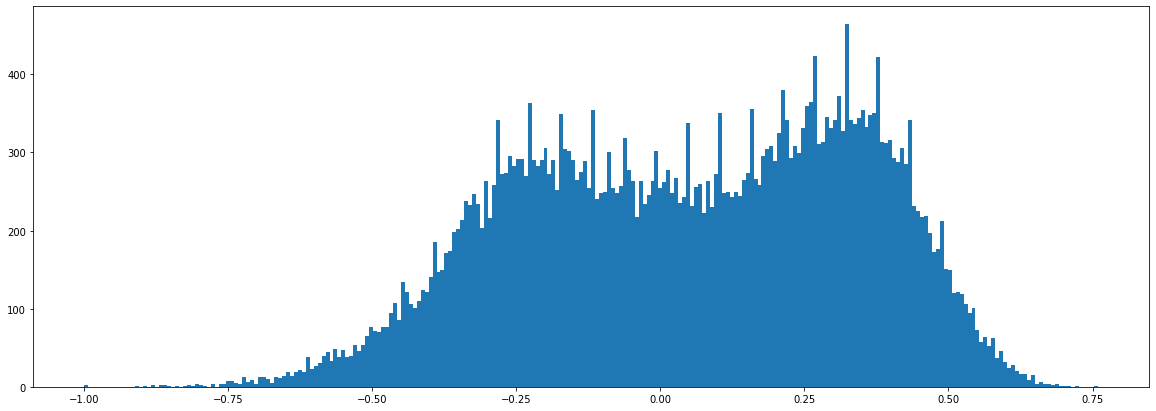

In [112]:
training_dataframe = pd.read_csv('training_data.csv', sep=';')
t_avg = (training_dataframe['d_tx'].values + training_dataframe['d_tn'].values)*0.5
print(np.min(t_avg), np.max(t_avg), np.average(t_avg))
training_data = (t_avg-10)/30
hist(training_data, 256);

###Model creation

The model shown below was trained earlier in a different notebook, so the cell outputs cannot show the training process. This code is a cleaned-up version of what was used during training. The hyperparameters were determined through multiple days of experimentation. The size of the model is fit for yearly periodic data prediction.

In [0]:
# datasets_root = "/content/gdrive/My Drive/Colab Notebooks/Muzsika/"
path_to_audio_train = datasets_root
input_size = 512
num_filters = 8
kernel_size = 2
num_residual_blocks = 6

model_filename = "temperature.h5"
wavenet = build_wavenet_model(input_size, num_filters, kernel_size, num_residual_blocks)

The model graph:

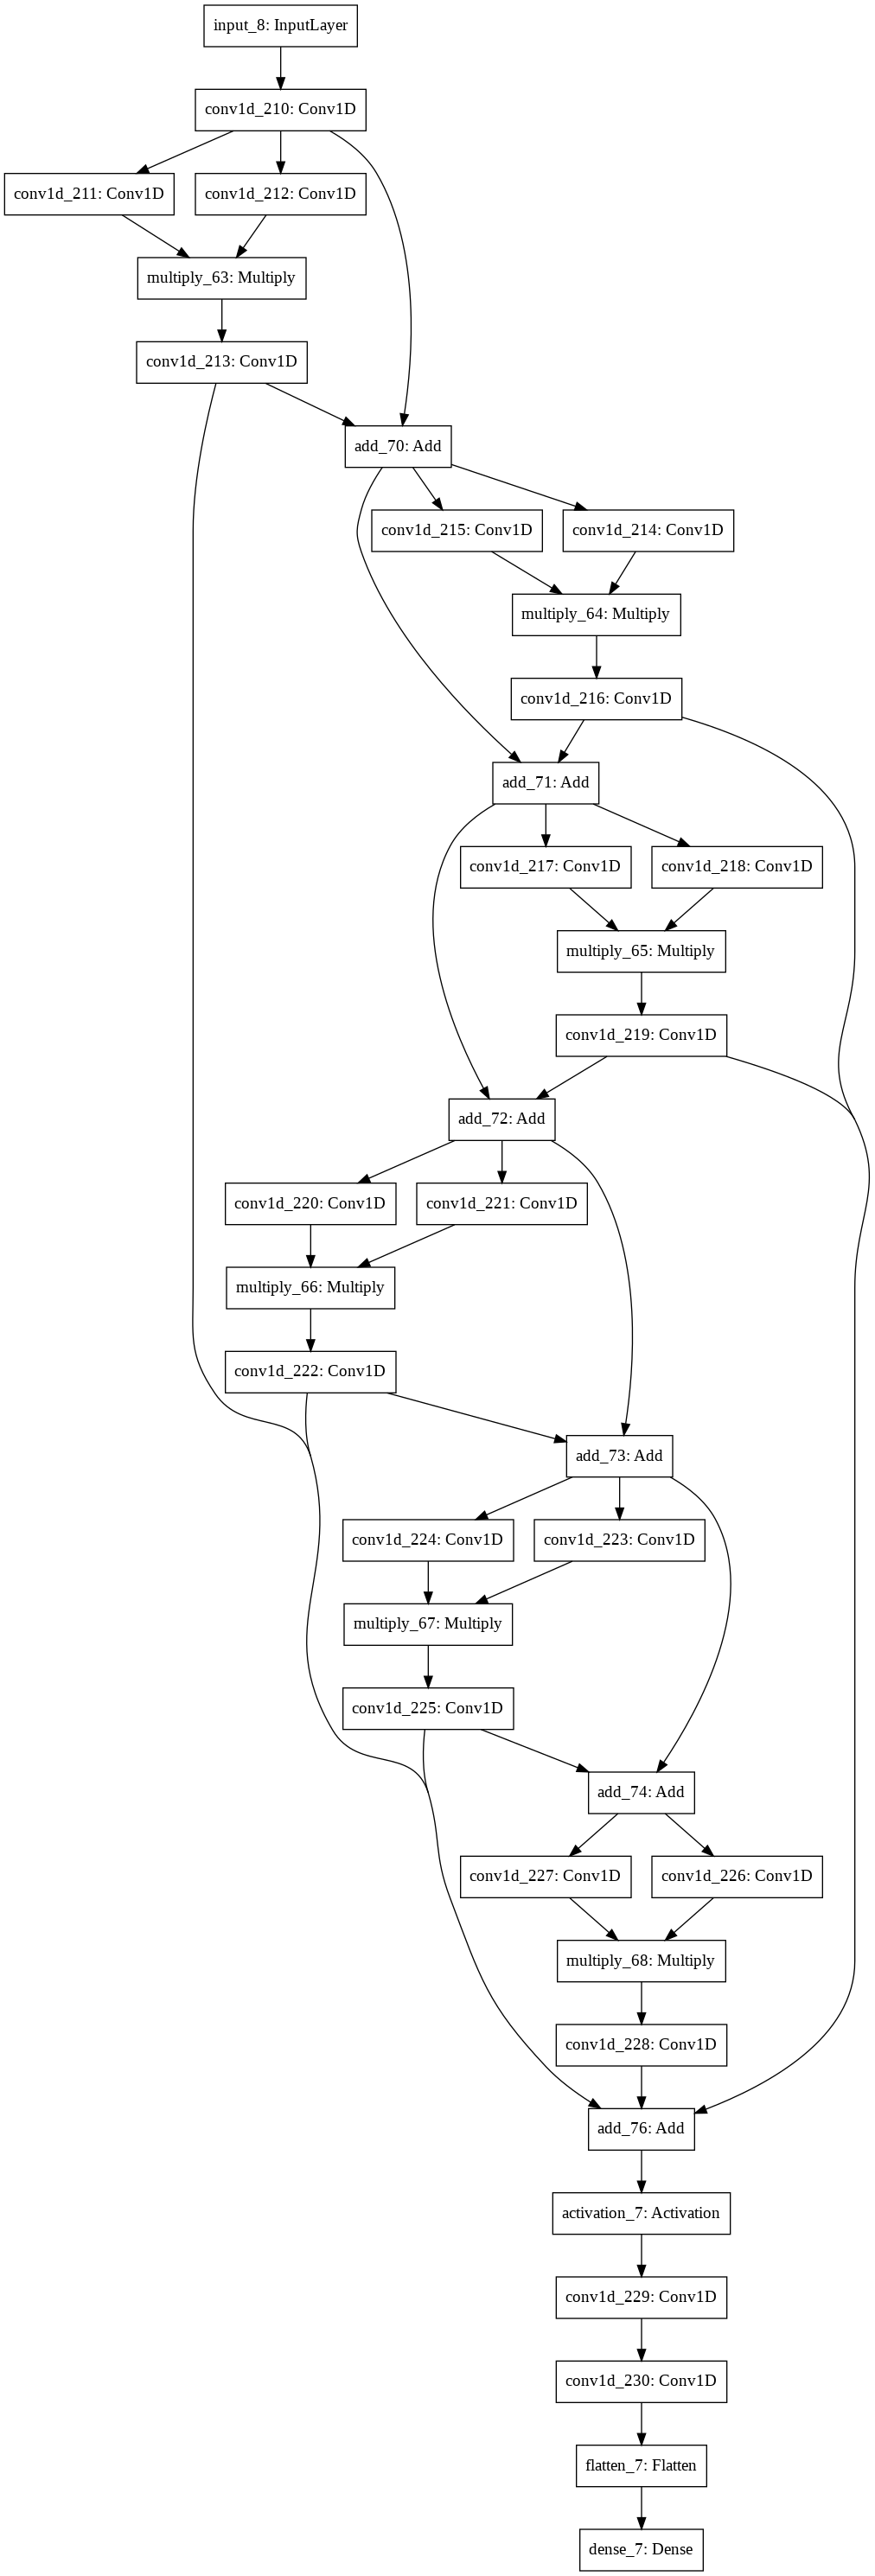

In [134]:
plot_model(wavenet, to_file=("temperature.h5"[:-3] + '.png'))

The code used to adjust learning rate:

In [0]:
print("Changing learning rate from", K.get_value(wavenet.optimizer.lr), end='')
K.set_value(wavenet.optimizer.lr, 0.0002)
print(" to", K.get_value(wavenet.optimizer.lr))

...and to get the learning rate:

In [0]:
K.get_value(wavenet.optimizer.lr)

Custom callback for loss and accuracy logging through multiple learning runs:

In [0]:
class LossHistory(Callback):
    def __init__(self):
        self.batch = 0
        self.batches = []
        self.loss = []
        self.acc = []
        self.val_batches = []
        self.val_loss = []
        self.val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.batch += 1
        self.batches.append(self.batch)
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))

    def on_test_batch_end(self, batch, logs={}):
        self.val_batches.append(self.batch)
        self.val_loss.append(logs.get('loss'))
        self.val_acc.append(logs.get('accuracy'))

training_history = LossHistory()

Code for training. The number of epochs, steps and batch size is adjusted during training. The validation parameters are not to be changed.

In [0]:
epochs = 30
steps = 36
batch_size = 1000

val_batch_size = 1000
val_split = 0.05
val_steps = 5

checkpointer = ModelCheckpoint(model_filename, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

print("Training WaveNet:", model_filename)
start_time = time.time()
wavenet.fit_generator(
    train_generator(training_data, batch_size, receptive_field_size=input_size, shuffle=True, validation_data=False, validation_split=val_split),
    validation_data=train_generator(training_data, val_batch_size, receptive_field_size=input_size, validation_data=True, validation_split=val_split, validation_steps=val_steps),
    validation_steps=val_steps,
    epochs=epochs,
    steps_per_epoch=steps,
    shuffle=False,
    callbacks=[checkpointer, reduce_lr, early_stopping, training_history])
elapsed_s = time.time()-start_time
print(f'Finished in {int(elapsed_s//3600):02d}:{int((elapsed_s%3600)//60):02d}:{elapsed_s%3600%60:02.3f} at {datetime.datetime.now()} UTC')

Code for loss and accuracy visualisation. As the training was done earlier, no output can be shown.

In [0]:
figure(figsize(10,7))
semilogy(training_history.batches, training_history.loss);
semilogy(training_history.val_batches, training_history.val_loss);

figure(figsize(10,7))
plot(training_history.batches, training_history.acc);
plot(training_history.val_batches, training_history.val_acc);

##Prediction

Loading testing data. This was complied from multiple [idojarasbudapest.hu](http://idojarasbudapest.hu/archivalt-idojaras) queries and contains the latest daily weather data for Budapest. The last value is for the 28th of October.

-13.0 32.5 12.475397418478261


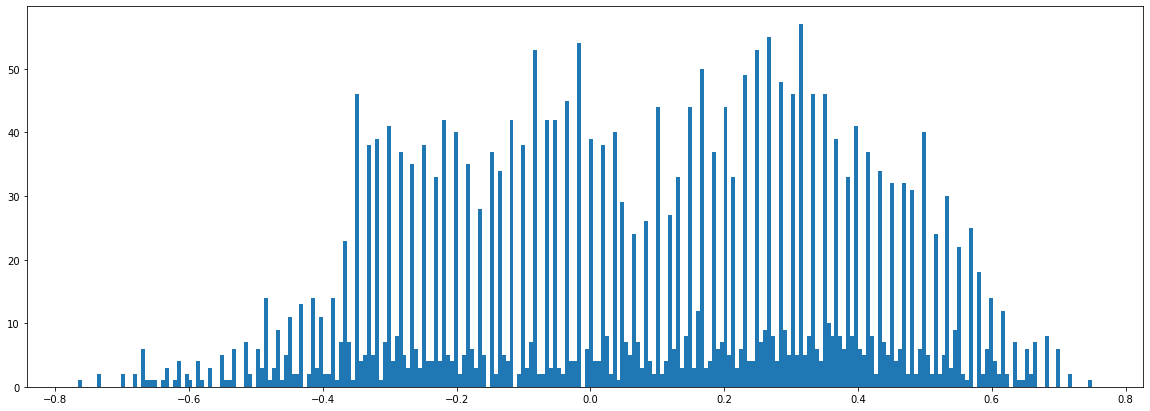

In [139]:
testing_dataframe = pd.read_csv('testing_data.csv', sep='\t')
t_avg = (testing_dataframe['Tmax'].values + testing_dataframe['Tmin'].values)*0.5
print(np.min(t_avg), np.max(t_avg), np.average(t_avg))
testing_data = (t_avg-10)/30
hist(testing_data, 256);

Loading pre-trained model for prediction:

In [0]:
wavenet = load_model("temperature.h5")

We need to predict 33 days of mean temperatures. For that we initialize the model with the last 512 known daily means and let it generate the next sample. We than decode the generated one-hot encoded sample, shift the input by one and append it to its end to feed it to the net once again.

In [0]:
prediction_length = 33

predicted_temperatures = testing_data[-input_size:]
predicted_days = 0
while predicted_days < prediction_length:
    probability_distribution = wavenet.predict(predicted_temperatures[predicted_days:].reshape(1, input_size, 1)).flatten()
    next_temperature = prediction_to_waveform_value(probability_distribution)
    predicted_temperatures = np.append(predicted_temperatures, next_temperature)
    predicted_days += 1

predicted_temperatures = predicted_temperatures * 30 + 10

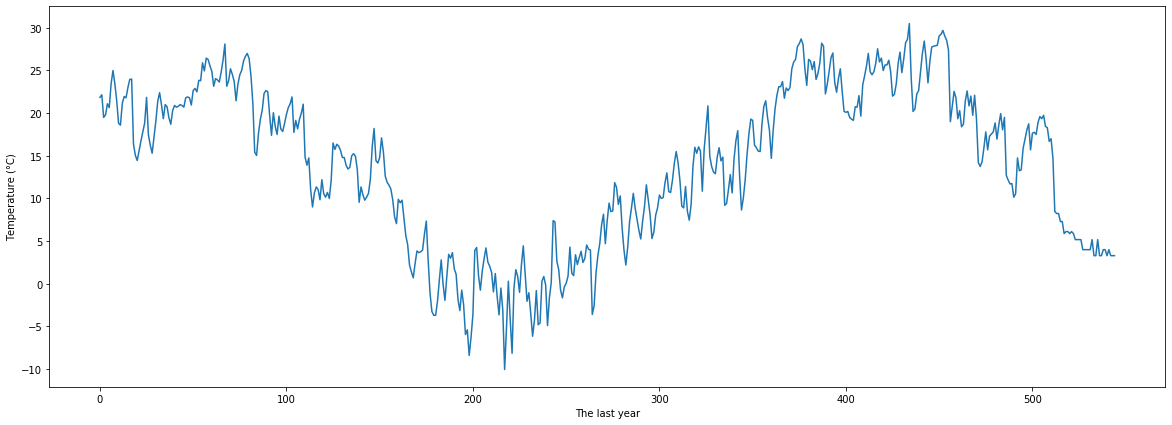

In [146]:
figure(figsize(20,7))
plot(predicted_temperatures);
xlabel("The last year");
ylabel("Temperature (°C)");

And the long awaited predictions:

In [151]:
print(f"The mean temperature tomorrow (30th of October) will be: {predicted_temperatures[511 + 2]:.1f} °C")
print(f"Next week (5th of November) it will be: {predicted_temperatures[511 + 8]:.1f} °C")
print(f"And in one month (26th of November) it is most definitely going to be: {predicted_temperatures[-1]:.1f} °C")

The mean temperature tomorrow (30th of October) will be: 8.2 °C
Next week (5th of November) it will be: 6.1 °C
And in one month (26th of November) it is most definitely going to be: 3.3 °C
